In [1]:
import torch
import torch.nn as nn
import numpy as np
import pickle
from random import random
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install space-bandits
from space_bandits import load_model, BanditAlgorithm
clear_output()

In [ ]:
## plug in gdrive to load the data from gdrive
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import sys
## path to the contextual_dataset_wu.py and toy_problem_wu.py files
path = '/content/drive/MyDrive/Fellowship_Deep_and_Wide_Bandit/Wide_and_Deep_Models/wd_models_jenny/'
sys.path.append(path)

from contextual_dataset_wu import ContextualDataset
from toy_problem_wu import generate_dataframe

# Define Models

Wide Model:
*   Input - User ID
*   Output - Expected reward for each action

Deep Model:
*   Input - Context
*   Output - Expected reward for each action

Wide and Deep Model: 

*   Combines output from the Wide model and the Deep model



In [4]:
class Wide_Model(nn.Module):
    def __init__(self, embed_size=100, n_action=2, embed_dim=64):
        ## Learns expected reward for each action given User ID
        ## Uses embeddings to 'memorize' individual users
        ## embed_size - size of the dictionary of embeddings
        ## embed_dim -  size of each embedding vector
        ## n_action - number of possible actions

        super(Wide_Model, self).__init__()
        self.embed_size = embed_size
        self.n_action = n_action
        self.embed_dim = embed_dim
        
        self.embedding = nn.Embedding(self.embed_size, self.embed_dim)
        self.lr = nn.Linear(self.embed_dim, self.n_action)
    
    def forward(self, x):
        ## Input: user ID
        x = self.embedding(x)
        x = self.lr(x)
        return x.squeeze(axis=0)


class Deep_Model(nn.Module):
    def __init__(self, context_size=5, layer_sizes=[50,100], n_action=2):
        ## Learns expected reward for each action given context
        ## layer_sizes (list of integers): defines neural network architecture: n_layers = len(layer_sizes), 
        ## value is per-layer width. (default [50,100])
        super(Deep_Model, self).__init__()
        self.context_size = context_size
        self.layer_sizes = layer_sizes
        self.n_action = n_action

        self.layers = []
        self.build_model()
        self.activation = nn.ReLU()
    
    def build_layer(self, inp_dim, out_dim):
        """Builds a layer in deep model """
        layer = nn.modules.linear.Linear(inp_dim,out_dim)
        nn.init.uniform_(layer.weight)
        name = f'layer {len(self.layers)}'
        self.add_module(name, layer)
        return layer
    
    def build_model(self):
        """
        Defines the actual NN model with fully connected layers.
        """
        for i, layer in enumerate(self.layer_sizes):
            if i==0:
                inp_dim = self.context_size
            else:
                inp_dim = self.layer_sizes[i-1]
            out_dim = self.layer_sizes[i]
            new_layer = self.build_layer(inp_dim, out_dim)
            self.layers.append(new_layer)
        output_layer = self.build_layer(out_dim, self.n_action)
        self.layers.append(output_layer)

    def forward(self, x):
        """forward pass of the neural network"""
        ## Input: context
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i != len(self.layers)-1:
                x = self.activation(x)
        return x.squeeze(axis=0)
  

class Wide_and_Deep_Model(nn.Module):
    def __init__(self, context_size=5, deep_layer_sizes=[50,100], n_action=2, embed_size=100, wide_embed_dim=64):
        super(Wide_and_Deep_Model, self).__init__()
        self.n_action = n_action
        self.context_size = context_size
        self.deep_layer_sizes = deep_layer_sizes
        self.embed_size = embed_size
        self.wide_embed_dim = wide_embed_dim

        self.wide_model = Wide_Model(embed_size=self.embed_size, n_action=self.n_action, embed_dim=self.wide_embed_dim)
        self.deep_model = Deep_Model(context_size=self.context_size, layer_sizes=self.deep_layer_sizes, n_action=self.n_action)
    
    def forward(self, wide_input, deep_input):
        x_wide = self.wide_model(wide_input)
        x_deep = self.deep_model(deep_input)

        ## Concatenate outputs from wide and deep model
        if len(x_wide.size()) == 1:
          x = torch.cat((x_wide,x_deep))
        elif len(x_wide.size()) > 1:
          x = torch.cat((x_wide,x_deep), dim=1)

        return x.squeeze(-1)

# Test the wide and deep model
Three modes: wide, deep, or wide_deep (Use the model_type keyword)

In [5]:
class Test_Wide_Deep_Bandits(BanditAlgorithm):
    def __init__(
        self,
        num_actions,
        num_features,
        wide_embed_size=100,
        wide_embed_dim=64,
        model_type = 'wide_deep', ## model_type = 'wide', 'deep', or 'wide_deep'
        name='test_deep_bandits'):
      
        hparams = {
                    'num_actions':num_actions,
                    'context_dim':num_features,
                    'max_grad_norm':5.0,
        }

        ## Raise error if model_type is not one of the available models
        possible_models = ['deep','wide','wide_deep']
        if model_type not in possible_models:
          raise NameError('model_type must be "deep", "wide", or "wide_deep"')

        self.name = name
        self.model_type = model_type
        self.wide_embed_dim = wide_embed_dim
        self.wide_embed_size = wide_embed_size
        self.hparams = hparams

        ## Initialize model and optimizer depeding on model_type
        if self.model_type == 'deep':
          self.deep_model = Deep_Model(context_size=self.hparams['context_dim'],
                                       n_action=self.hparams['num_actions'])
          self.optim = torch.optim.RMSprop(self.deep_model.parameters())

        if self.model_type == 'wide':
          self.wide_model = Wide_Model(embed_size=self.wide_embed_size, 
                                      n_action=self.hparams['num_actions'], 
                                      embed_dim=self.wide_embed_dim)
          self.optim = torch.optim.RMSprop(self.wide_model.parameters())
        

        if self.model_type == 'wide_deep':
          self.wide_deep_model = Wide_and_Deep_Model(context_size=self.hparams['context_dim'],
                                                    embed_size=self.wide_embed_size, 
                                                    n_action=self.hparams['num_actions'], 
                                                    wide_embed_dim=self.wide_embed_dim) 
          self.optim = torch.optim.RMSprop(self.wide_deep_model.parameters())
        
        self.loss = nn.modules.loss.MSELoss()

        self.t = 0
        self.update_freq_nn = 1
        self.num_epochs = 1
        self.data_h = ContextualDataset(self.hparams['context_dim'],
                                        self.hparams['num_actions'],
                                        intercept=False)
        self.user_dict = []

    def expected_values(self, user_id, context):
        ## Return expected reward for each possible action
        context = torch.tensor(context).float()

        n_act=self.hparams['num_actions'] ## Number of actions for combining wide and deep outputs

        if self.model_type == 'deep':
          x = self.deep_model.forward(context)
        if self.model_type == 'wide':
          x = self.wide_model.forward(user_id)
        if self.model_type == 'wide_deep':
          x = self.wide_deep_model.forward(user_id, context)
          x = x[0:n_act]+x[n_act:n_act*2] ## Add the output from wide and deep model
        return x

    def action(self, user_id, context):
        ## Select and action based on expected values of reward
        
        if self.model_type == 'deep':
          vals = self.expected_values(user_id, context)  
        if self.model_type == 'wide':
          vals = self.expected_values(user_id, context)   
        if self.model_type == 'wide_deep':
          vals = self.expected_values(user_id, context)  
        return np.argmax(vals.detach().numpy())
        
    def update(self, user_id, context, action, reward):
        """
        Args:
          context: Last observed context.
          action: Last observed action.
          reward: Last observed reward.
        """
        self.t += 1
        self.data_h.add(user_id, context, action, reward)

        if self.t % self.update_freq_nn == 0:
          self.train(self.data_h, self.num_epochs)
                
    def do_step(self, u, x, y, w, step):

        if self.model_type == 'deep':
          y_hat = self.deep_model.forward(x.float())
        if self.model_type == 'wide':
          y_hat = self.wide_model.forward(u)
        if self.model_type == 'wide_deep':
          y_hat = self.wide_deep_model(u,x.float())
          ## replicate y and w to compare with concatenated y_hat from wide_deep model
          y = torch.cat((y,y), dim=1) 
          w = torch.cat((w,w), dim=1)

        y_hat *= w
        ls = self.loss(y_hat, y.float())
        ls.backward()

        clip = self.hparams['max_grad_norm']

        if self.model_type == 'deep':
          torch.nn.utils.clip_grad_norm_(self.deep_model.parameters(), clip)
        if self.model_type == 'wide':
          torch.nn.utils.clip_grad_norm_(self.wide_model.parameters(), clip)
        if self.model_type == 'wide_deep':
          torch.nn.utils.clip_grad_norm_(self.wide_deep_model.parameters(), clip)

        self.optim.step()
        self.optim.zero_grad()

    def train(self, data, num_steps):
        """Trains the network for num_steps, using the provided data.
        Args:
          data: ContextualDataset object that provides the data.
          num_steps: Number of minibatches to train the network for.
        """
        #print("Training {} for {} steps...".format(self.name, num_steps))

        batch_size = 512

        data.scale_contexts()

        for step in range(num_steps):
            u, x, y, w = data.get_batch_with_weights(batch_size, scaled=True)

            ## Training at time step 1 will cause problem if scaled=True, 
            ## because standard deviation=0, and scaled_context will equal nan
            if self.t != 1:   
              self.do_step(u, x, y, w, step)
    
    def save(self, path):
        """saves model to path"""
        with open(path, 'wb') as f:
            pickle.dump(self, f)

# Toy problem
The space-bandits toy_problem divides users/customers into two groups

Group 1: age ~25, ARPU ~100, user_id range 0 - 19

Group 2: age ~45, ARPU ~50, user_id range 20 - 39

    There are three actions:
    promo 1: low value. 10 dollar if accept
    promo 2: mid value. 25 dollar if accept
    promo 3: high value. 100 dollar if accept

    Both groups are unlikely to accept promo 2.
    Group 1 is more likely to accept promo 1.
    Group 2 is slightly more likely to accept promo 3.

    The optimal choice for group 1 is promo 1; 90% acceptance for
    an expected reward of 9 dollars each.
    Group 2 accepts with 25% rate for expected 2.5 dollar reward

    The optimal choice for group 2 is promo 3; 20% acceptance for an expected
    reward of 20 dollars each.
    Group 1 accepts with 2% for expected reward of 2 dollars.

    The least optimal choice in all cases is promo 2; 10% acceptance rate for both groups
    for an expected reward of 2.5 dollars.

In [9]:
## Get training data from toy_problem
n_train_samples = 1000
df = generate_dataframe(n_train_samples)
context_cols = ['age','ARPU']
action_col = ['action']
reward_col = ['reward']
user_id_col = ['user_id']
df.head()

,age,ARPU,action,reward,user_id
0,43.0,84.114383,0,0,23
1,18.0,94.666115,2,0,13
2,43.0,87.069622,1,0,31
3,24.0,86.392096,2,0,9
4,43.0,44.457383,0,10,23


In [8]:
num_actions = df[action_col].nunique()[0]
num_features = len(context_cols)
num_users = df[user_id_col].nunique()[0]
print("Number of actions:", num_actions)
print("Number of features:", num_features)
print("Number of users:", num_users)

Number of actions: 3
Number of features: 2
Number of users: 40


# Train/Save/Load models

In [10]:
%%time

### Train models 
demo_model_wide = Test_Wide_Deep_Bandits(num_actions, num_features, wide_embed_size=num_users+10, model_type='wide')
demo_model_deep = Test_Wide_Deep_Bandits(num_actions, num_features, wide_embed_size=num_users+10, model_type='deep')
demo_model_wide_deep = Test_Wide_Deep_Bandits(num_actions, num_features, wide_embed_size=num_users+10, model_type='wide_deep')

for i in range(n_train_samples):
  test_context = df[context_cols].iloc[i].values
  test_action = df[action_col].iloc[i].values
  test_reward = df[reward_col].iloc[i].values
  test_user_id = df[user_id_col].iloc[i].values

  demo_model_wide.update(torch.tensor(df[user_id_col].iloc[i].values), test_context,test_action,test_reward)
  demo_model_deep.update(torch.tensor(df[user_id_col].iloc[i].values), test_context,test_action,test_reward)
  demo_model_wide_deep.update(torch.tensor(df[user_id_col].iloc[i].values), test_context,test_action,test_reward)


CPU times: user 24.5 s, sys: 165 ms, total: 24.7 s
Wall time: 25 s


In [ ]:
## Save models
#demo_model_wide.save(path+'test_model_wide.pkl')
#demo_model_deep.save(path+'test_model_deep.pkl')
#demo_model_wide_deep.save(path+'test_model_wide_deep.pkl')

In [ ]:
## Load existing models
#demo_model_wide = load_model(path+'test_model_wide.pkl')
#demo_model_deep = load_model(path+'test_model_deep.pkl')
#demo_model_wide_deep = load_model(path+'test_model_wide_deep.pkl')

# Model Performance

In [11]:
## Get another set of randomly generated data from toy_problem
n_val_samples = 1000
df_val = generate_dataframe(n_val_samples)
df_val.head()

,age,ARPU,action,reward,user_id
0,24.0,94.339959,0,10,8
1,27.0,94.919022,1,0,14
2,44.0,52.063453,0,10,25
3,33.0,83.091608,2,0,11
4,21.0,80.959477,2,0,12


In [12]:
df_val['avg_reward_action_1'] = 0.
df_val['avg_reward_action_2'] = 0.
df_val['avg_reward_action_3'] = 0.

df_val['best_action'] = 0
df_val['model_action'] = 0
df_val['optimal_reward'] = 0.

In [13]:
## Group 1, user_id 0 - 19
## 90% chance of accepting promo 1 (10 dollars revenue) - average reward 9 dollars
## 10% chance of accepting promo 2 (25 dollars revenue) - average reward 2.5 dollars
## 2% chance of accepting promo 3 (100 dollars revenue) - average reward 2 dollars
## Best action - 0 (promo 1), optimal reward 9 dollars
df_val['avg_reward_action_1'].loc[df_val['user_id']<20] = 0.9 * 10
df_val['avg_reward_action_2'].loc[df_val['user_id']<20] = 0.1 * 25
df_val['avg_reward_action_3'].loc[df_val['user_id']<20] = 0.02 * 100
df_val['best_action'].loc[df_val['user_id']<20] = 0
df_val['optimal_reward'].loc[df_val['user_id']<20] = 0.9 * 10

## Group 2, user_id 20 - 39
## 25% chance of accepting promo 1 (10 dollars revenue) - average reward 2.5 dollars
## 10% chance of accepting promo 2 (25 dollars revenue) - average reward 2.5 dollars
## 20% chance of accepting promo 3 (100 dollars revenue) - average reward 20 dollars
## Best action - 0 (promo 3), optimal reward 20 dollars
df_val['avg_reward_action_1'].loc[df_val['user_id']>=20] = 0.25 * 10
df_val['avg_reward_action_2'].loc[df_val['user_id']>=20] = 0.1 * 25
df_val['avg_reward_action_3'].loc[df_val['user_id']>=20] = 0.2 * 100
df_val['best_action'].loc[df_val['user_id']>=20] = 2
df_val['optimal_reward'].loc[df_val['user_id']>=20] = 0.2 * 100

clear_output()


In [14]:
df_val.head()

,age,ARPU,action,reward,user_id,avg_reward_action_1,avg_reward_action_2,avg_reward_action_3,best_action,model_action,optimal_reward
0,24.0,94.339959,0,10,8,9.0,2.5,2.0,0,0,9.0
1,27.0,94.919022,1,0,14,9.0,2.5,2.0,0,0,9.0
2,44.0,52.063453,0,10,25,2.5,2.5,20.0,2,0,20.0
3,33.0,83.091608,2,0,11,9.0,2.5,2.0,0,0,9.0
4,21.0,80.959477,2,0,12,9.0,2.5,2.0,0,0,9.0


In [16]:
def evaluate_model(df_val = df_val, model = demo_model_wide_deep, val_size=1000, 
                   context_cols = ['age','ARPU'], user_id_col = ['user_id'],
                   epsilon = 0.0):

  ## means and standard deviation for scaling the context columns
  val_context_means = df_val[context_cols].mean().values
  val_context_std = df_val[context_cols].std().values

  model_reward = 0.
  optimal_reward = 0.
  n_rand_act = 0

  cum_model_reward = []
  cum_optimal_reward = []

  for i in range(val_size):
    val_context = (df_val[context_cols].iloc[i].values - val_context_means) / val_context_std
    val_user_id = torch.tensor(df_val[user_id_col].iloc[i].values)

    ## Get predicted best action from model
    action = model.action(val_user_id, val_context)

    ## Select action in using epsilon-greedy 
    ## epsilon set to 0 by default, which is just greedy
    if random() < epsilon:
      n_rand_act += 1
      action = np.random.randint(0,3)
    
    df_val['model_action'].loc[i] = action

    ## Get reward for action and add to model_reward
    if action == 0:
      pred_reward = df_val['avg_reward_action_1'].iloc[i]
      model_reward += pred_reward
    elif action == 1:
      print()
      pred_reward = df_val['avg_reward_action_2'].iloc[i]
      model_reward += pred_reward
    elif action == 2:
      pred_reward = df_val['avg_reward_action_3'].iloc[i]
      model_reward += pred_reward
    
    ## Get optimal reward and add to optimal_reward
    this_optimal_reward = df_val['optimal_reward'].iloc[i]
    optimal_reward += this_optimal_reward
  
    cum_model_reward.append(model_reward)
    cum_optimal_reward.append(optimal_reward)

  ## What fraction of the optimal reward did we get?
  reward_percentage = model_reward / optimal_reward * 100.
  regret = optimal_reward - model_reward

  clear_output()
  print("Model received",reward_percentage,"% of the optimal reward")
  print("Regret = ",regret)
  
  cf_matrix = confusion_matrix(df_val['best_action'], df_val['model_action'])
  ax = plt.axes()
  sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',annot_kws={"fontsize":16}, ax = ax)
  ax.set_title('Confusion Matrix')
  plt.show()
  #print("")
  #print(confusion_matrix(df_val['best_action'], df_val['model_action'], labels=[0, 1, 2]))
  #print("Randomly chose action {}% of the time".format(n_rand_act/val_size))
  #print("")

  cum_model_reward = np.array(cum_model_reward)
  cum_optimal_reward = np.array(cum_optimal_reward)
  steps = np.array(range(val_size))

  #plt.scatter(steps,cum_model_reward,color='r')
  #plt.scatter(steps,cum_optimal_reward,color='b')
  #plt.title("Cumulative Rewards (Model vs. Optimal)")
  #plt.xlabel("Steps")
  #plt.ylabel("Rewards")
  #plt.show()


  fig, ax = plt.subplots()
  ax.scatter(steps, cum_model_reward, color='r', label='Model')
  ax.scatter(steps, cum_optimal_reward, color='b', label='Optimal')
  plt.title("Cumulative Rewards (Model vs. Optimal)")
  plt.xlabel("Steps")
  plt.ylabel("Rewards")
  ax.legend()
  plt.show()

# Evaluation Output:


Model received 77.18895611655887 % of the optimal reward
Regret =  3280.0


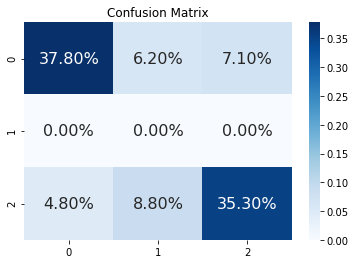

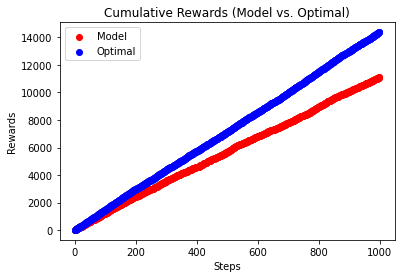

In [17]:
evaluate_model(model = demo_model_wide, epsilon = 0.1, val_size=n_val_samples)

Model received 87.63126782112803 % of the optimal reward
Regret =  1778.5


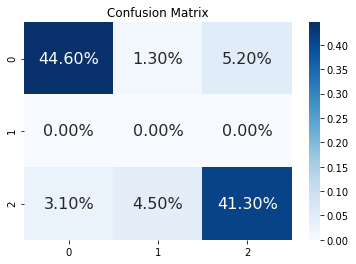

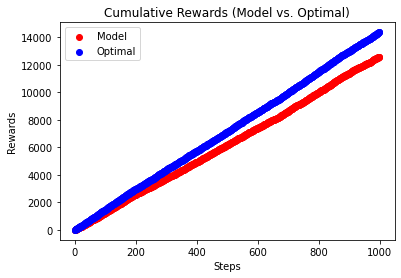

In [18]:
evaluate_model(model = demo_model_deep, epsilon = 0.1, val_size=n_val_samples)

Model received 90.08623687321789 % of the optimal reward
Regret =  1425.5


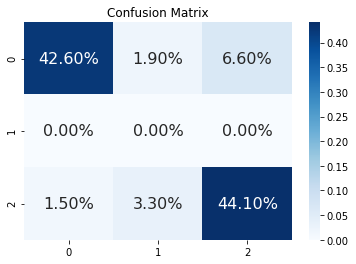

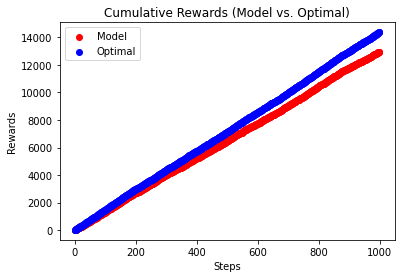

In [19]:
evaluate_model(model = demo_model_wide_deep, epsilon = 0.1, val_size=n_val_samples)